<a href="https://colab.research.google.com/github/namirinz/YSC21-AI_KME/blob/master/Image_Captioning/KME_Image_captioning_luong.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Library

In [1]:
!pip install nami --upgrade
!rm -rf .keras

Requirement already up-to-date: nami in /usr/local/lib/python3.6/dist-packages (1.3.1.2)


In [2]:
!pip install nltk

In [3]:
import nami
import time
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import trange, tqdm


In [4]:
!nvidia-smi -L

GPU 0: Tesla P100-PCIE-16GB (UUID: GPU-c951caf8-ccb6-bd2f-254a-4ef33a6d110d)


# Import Dataset

In [5]:
from nami.datasets.kme import load_data
(image_train, caption_train), (image_test, caption_test) = load_data(test_size = 0.3)

In [6]:
print(image_train.shape)
print(image_test.shape)

(660, 300, 300, 3)
(283, 300, 300, 3)


## Preprocessing Dataset

In [7]:
from nami.AI.kme_tokenize import Tokenizer
tokenizer = Tokenizer()

In [8]:
tokenizer.fit_on_texts(caption_train)

In [9]:
text2seq_train = tokenizer.text_to_sequences(caption_train)
seq2text_train = tokenizer.sequences_to_text(text2seq_train)

In [10]:
text2seq_test = tokenizer.text_to_sequences(caption_test)
seq2text_test = tokenizer.sequences_to_text(text2seq_test)

## Hyperparameter

In [11]:
BATCH_SIZE = 16
BUFFER_SIZE = 1000
units = 512
vocab_size = len(tokenizer.word2index)

num_steps_train = len(image_train) // BATCH_SIZE
num_steps_test = len(image_test) // BATCH_SIZE

max_length_train = text2seq_train.shape[1]
max_length_test = text2seq_test.shape[1]

encoding_size = 512 # Determines dimension of the encodings of images

# Create Dataset

In [12]:
def preprocess_fn(image):
  image = preprocess_input(image)

  # Add some noise
  rand = tf.random.uniform([1], 0, 10, dtype=tf.float32) * 0.01
  gnoise = tf.random.normal(shape=tf.shape(image), mean=0.0, stddev=rand, dtype=tf.float32)
  image = tf.add(image, gnoise)
  
  return image

## ImageDataGenerator

In [13]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# zoom in by 80%, zoom out by 100%

datagen = ImageDataGenerator(
    rotation_range = 45, zoom_range = [0.8, 1.0],
    width_shift_range = 0.1, height_shift_range = 0.1,
    horizontal_flip = True, vertical_flip = True,
    #preprocessing_function = preprocess_fn
)

datagen_val = ImageDataGenerator(
    #preprocessing_function =  preprocess_input
)

## tf.data.Dataset

In [14]:
dataset = tf.data.Dataset.from_generator(
    lambda : datagen.flow( image_train, text2seq_train, batch_size = BATCH_SIZE, shuffle = True, seed = 123 ),
    output_types = (tf.float32, tf.float32)
).cache(
).prefetch(
    tf.data.experimental.AUTOTUNE
)

dataset_val = tf.data.Dataset.from_generator(
    lambda : datagen_val.flow( image_test, text2seq_test, batch_size = BATCH_SIZE, shuffle =  False, seed = 123 ),
    output_types = (tf.float32, tf.float32)
).cache(
).prefetch(
    tf.data.experimental.AUTOTUNE
)

## ImageDataGenerator Hyperparameter Tuning

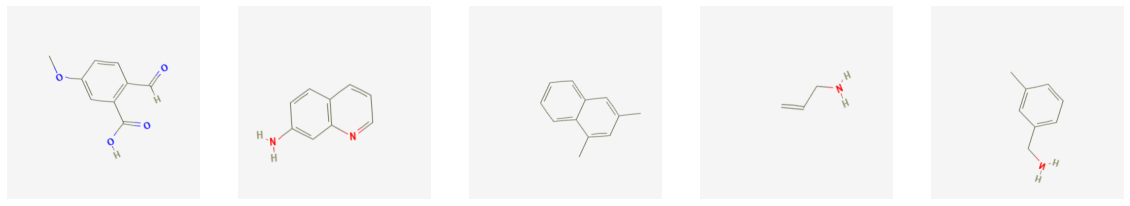

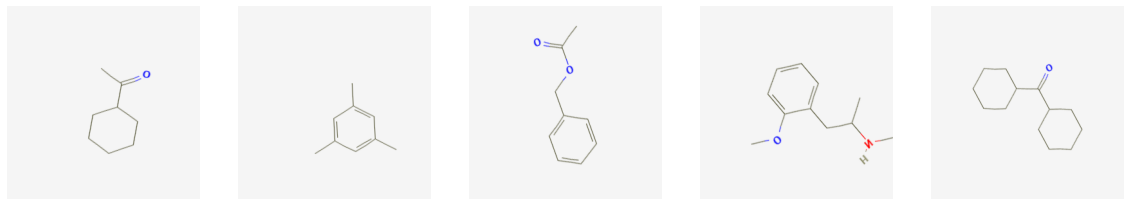

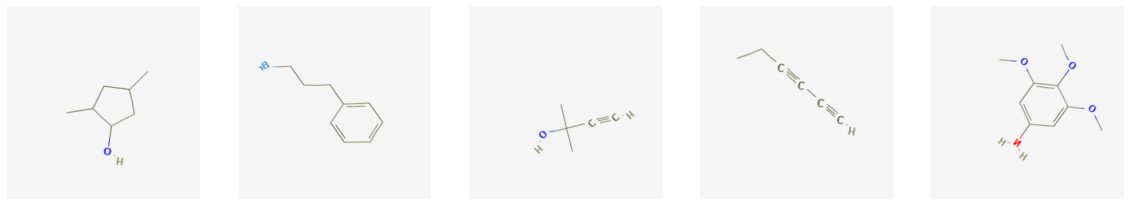

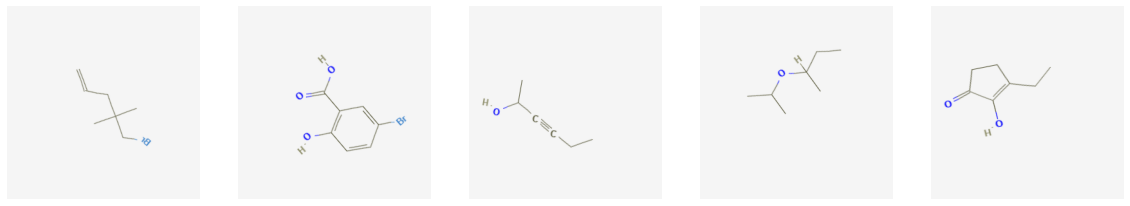

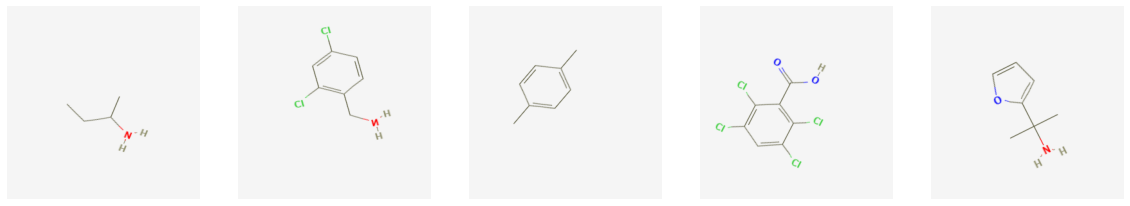

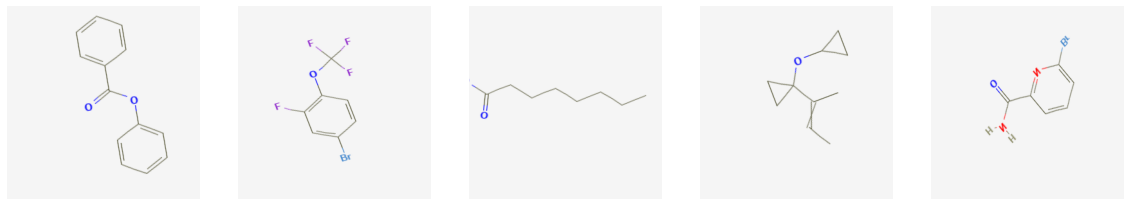

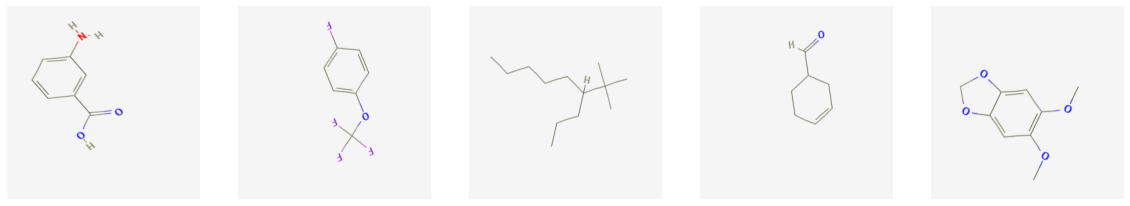

In [56]:
# Test parameter of ImageDataGenerator
for index, (img, label) in enumerate(dataset):
  plt.figure(figsize=(20, 20))
  for i in range(1, 6):
    plt.subplot(1, 5, i)
    plt.imshow( tf.cast(img[i], tf.uint8) )
    plt.axis('off')
  plt.show()
  if index == 6:
    break

# Model Architecture

## Efficientnet B3

In [16]:
from tensorflow.keras.applications.efficientnet import EfficientNetB7

pret_model = EfficientNetB7(include_top = False, weights='imagenet', input_shape=(300, 300, 3))

pret_model.trainable = False

attention_features_shape = 10 * 10
features_shape = 1536

# Xception : [7, 7, 2048]
# InceptionResNetV2 : [5, 5, 1536]
# EfficientNetB0 : [7, 7, 2560]

258080768/258076736 [==============================] - 11s 0us/step


In [17]:
pret_model.summary()

Model: "efficientnetb7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 300, 300, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 300, 300, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 300, 300, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 301, 301, 3)  0           normalization[0][0]              
_____________________________________________________________________________________

## CNN Encoder (Encoder output of feature extraction)

In [18]:
from tensorflow.keras.models import Sequential

def create_encoder():
  x = tf.keras.layers.Dense(encoding_size,activation='relu',name="encoding_layer")(pret_model.output)
  output = tf.keras.layers.Reshape(target_shape=(attention_features_shape, encoding_size))(x)
  return tf.keras.Model(pret_model.input, output)

In [19]:
encoder = create_encoder()

In [20]:
from tensorflow.keras.layers import BatchNormalization, AveragePooling2D

for index, layer in enumerate(encoder.layers):
  if index <= 20 and not isinstance(layer, BatchNormalization):
    layer.trainable = True

In [21]:
encoder.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 300, 300, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 300, 300, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 300, 300, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 301, 301, 3)  0           normalization[0][0]              
_______________________________________________________________________________________

## Luong Attention

In [22]:
from tensorflow.keras.layers import Dense, Embedding, GRU, LSTM

In [23]:
def create_attention(features, hidden, method = 'concat'):
  # features(CNN_encoder output) shape == (batch_size, 25, embedding_dim)
  # hidden shape == (batch_size, hidden_size)
  
  # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
  hidden_with_time_axis = tf.expand_dims(hidden, 1)
  
  if method == 'concat':
    attention_hidden_layer = tf.nn.tanh( Dense(units)(features + hidden) )
  elif method == 'general':
    attention_hidden_layer = tf.matmul( features, Dense(units)(hidden), transpose_b=True )
  elif attention_hidden_layer == 'dot':
    attention_hidden_layer = tf.matmul( features, hidden, transpose_b=True )
  
  score = Dense(1)(attention_hidden_layer)
  attention_weights = tf.nn.softmax(score, axis=1)

  context_vector = attention_weights * features
  context_vector = tf.reduce_sum(context_vector, axis=1)
  
  return context_vector, attention_weights

## Create RNN Decoder

In [24]:
def create_decoder():
  features = tf.keras.layers.Input((attention_features_shape, encoding_size))
  dec_input= tf.keras.layers.Input((1))
  hidden = tf.keras.layers.Input((units))

  embedded = Embedding(vocab_size, encoding_size)(dec_input)

  lstm_output, state = GRU(units,return_sequences=True,return_state=True,recurrent_initializer='glorot_uniform')(embedded, initial_state=[hidden])
 
  context_vector, attention_weights = create_attention(features, lstm_output)

  # embedded shape after concatenation == (batch_size, 1, encoding_size + hidden_size)
  output = tf.concat([context_vector, tf.squeeze(embedded, 1)], axis = -1)
  
  # shape == (batch_size, hidden_size)
  output = Dense(units, activation='tanh')(output)

  output = Dense(vocab_size, activation = 'softmax')(output)

  return tf.keras.models.Model([features, dec_input, hidden], [output, state, attention_weights])

def reset_state(batch_size):
  return tf.zeros((batch_size, units))

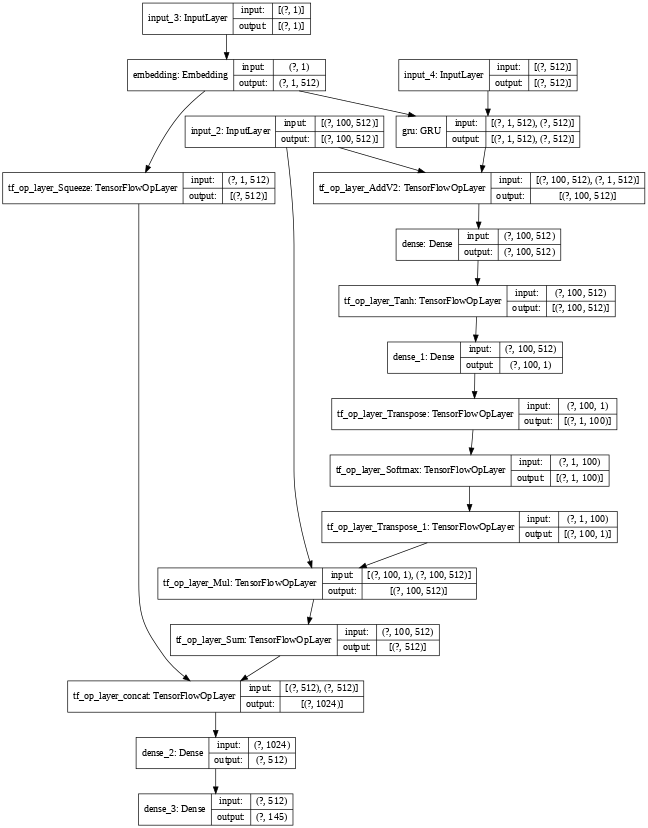

In [25]:
decoder = create_decoder()

tf.keras.utils.plot_model(decoder, show_shapes=True, dpi = 49)

# Custom Loss Function


In [26]:
def loss_fn(real, pred):
  # Word Loss

  real_onehot = tf.one_hot(tf.cast(real, tf.uint8), vocab_size)

  loss_object = tf.keras.losses.CategoricalCrossentropy(from_logits=False, reduction = 'none', label_smoothing=0.2)
  mask = tf.math.logical_not(tf.math.equal(real, tokenizer.word2index['<pad>'])) # make padding element -> true(1) -> false (0)
  loss_ = loss_object(real_onehot, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  # EOS Loss
  loss_object2 = tf.keras.losses.BinaryCrossentropy(from_logits=False, label_smoothing=0.2)

  end_token = tokenizer.word2index['<end>']
  pred_id = tf.math.argmax(pred, axis=-1)

  real_eos = tf.cast(tf.math.equal(real, end_token), dtype=tf.float32)
  pred_eos = tf.cast(tf.math.equal(pred_id, end_token), dtype=tf.float32)

  loss_2 = loss_object2(real_eos, pred_eos)

  return tf.reduce_mean(loss_) + loss_2 

# Metrics

In [27]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

class Bleu(tf.keras.metrics.Metric):
  def __init__(self, name='bleu', **kwargs):
    super(Bleu, self).__init__(name=name, **kwargs)
    self.score = self.add_weight(name='score', initializer='zeros')
    self.count = self.add_weight(name='count', initializer='zeros')
    self.chencherry = SmoothingFunction()

  def update_state(self, y_true, y_pred, sample_weight=None):
    y_true = y_true[y_true != tokenizer.word2index['<pad>']]
    idx = np.where(y_pred == tokenizer.word2index['<end>'])[0]

    if idx != []:
      y_pred = y_pred[:idx[0]+1]
          
    values = sentence_bleu([y_true], y_pred, smoothing_function=self.chencherry.method1)

    self.count.assign_add(1)
    self.score.assign_add(values)

  def result(self):
    return self.score / self.count

  def reset_states(self):
    self.count.assign(0)
    self.score.assign(0)

In [28]:
class EarlyStopping():
  def __init__(self, monitor = 'val_bleu', mode = 'max', patience = 1, encoder = encoder, decoder = decoder):
    if mode == 'max':
      self.mode = 'max'
      self.best = -100
    else: # Min
      self.min = 'min'
      self.best = 100
    self.patience = patience
    self.wait = 0
    self.encoder = encoder
    self.decoder = decoder

  def callback(self, log):
    if self.mode == 'max':
      if log < self.best:
        self.wait += 1
        if self.wait > self.patience:
          print('EarlyStopping : {} < best {} '.format(log, self.best))
          return True
      else :
        self.wait = 0
        self.best = log
        self.encoder.save('Encoder_model.h5', include_optimizer=False)
        self.decoder.save('Decoder_model.h5', include_optimizer=False)
    else:
      if log > self.best:
        self.wait += 1
        if self.wait > self.patience:
          print('EarlyStopping : {} > best {} '.format(log, self.best))
          return True
      else :
        self.wait = 0
        self.best = log
        self.encoder.save('Encoder_model.h5', include_optimizer=False)
        self.decoder.save('Decoder_model.h5', include_optimizer=False)
    
    return False
  

In [29]:
earlystop = EarlyStopping(patience = 10)

# Sub Class Model

In [30]:
opt = tf.keras.optimizers.Adam(0.0001)

train_acc = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')
val_acc = tf.keras.metrics.SparseCategoricalAccuracy(name='val_accuracy')
bleu = Bleu()
bleu_val = Bleu()

In [31]:
@tf.function
def train_step(img_tensor, target):
  batch_size = tf.shape(img_tensor)[0]

  hidden_state = reset_state(batch_size = batch_size)
  decoder_input = tf.ones([batch_size, 1])
  dec_train_pred = tf.ones([batch_size, 1], dtype=tf.int32)

  loss = 0 
  
  with tf.GradientTape() as tape:
    img_feature = encoder(img_tensor, training = True)

    for i in range(1, max_length_train):
      # passing the features through the decoder
      predictions, hidden_state, _ = decoder([img_feature, decoder_input, hidden_state], training = True)
      loss += loss_fn(target[:,i], predictions)
      
      predict_ids = tf.argmax(predictions, axis = -1, output_type= tf.int32)
      predict_ids = tf.reshape(predict_ids, (-1, 1))
      dec_train_pred = tf.concat( [dec_train_pred, predict_ids], axis = -1 )
      # using teacher forcing
      decoder_input = tf.expand_dims(target[:, i], 1)
      # Metrics
      train_acc.update_state(target[:, i], predictions)

  gradient = tape.gradient(loss, encoder.trainable_variables + decoder.trainable_variables) 
  opt.apply_gradients(zip(gradient, encoder.trainable_variables + decoder.trainable_variables))

  return {'pred': dec_train_pred, 'loss': loss / max_length_train, 'acc' : train_acc.result()}

In [32]:
@tf.function
def test_step(img_tensor, target):
  batch_size = tf.shape(img_tensor)[0]

  hidden_state = reset_state(batch_size = batch_size)
  decoder_input = tf.ones([batch_size, 1])
  dec_val_pred = tf.ones([batch_size, 1], dtype=tf.int32)

  loss = 0

  with tf.GradientTape() as tape:  
    img_feature = encoder(img_tensor, training = False)

    for i in range(1, max_length_test):
      predictions, hidden_state, _ = decoder([img_feature, decoder_input, hidden_state], training = False)
      loss += loss_fn(target[:,i], predictions)

      predict_ids = tf.argmax(predictions, axis = -1, output_type= tf.int32)
      predict_ids = tf.reshape(predict_ids, (-1, 1))
      dec_val_pred = tf.concat( [dec_val_pred, predict_ids], axis = -1 )
        
      decoder_input = tf.expand_dims(target[:, i], 1)

      val_acc.update_state(target[:, i], predictions)

  return {'pred': dec_val_pred, 'loss': loss/max_length_test, 'acc': val_acc.result()}

In [33]:
from IPython.display import clear_output, display

def fit(epochs, dataset, dataset_val, num_steps, num_steps_val):
  for epoch in trange(1, epochs+1):
    train_acc.reset_states()
    bleu.reset_states()

    for index, (image, caption) in tqdm(enumerate(dataset.take(num_steps)), total=num_steps, leave=False):
      monitor = train_step(image, caption)
  
      for i in range(tf.shape(caption)[0]):
        bleu.update_state(caption[i].numpy(), monitor['pred'][i].numpy())

    val_acc.reset_states()
    bleu_val.reset_states()

    for index, (image, caption) in tqdm(enumerate(dataset_val.take(num_steps_val)), total=num_steps_val, leave=False):
      monitor_val = test_step(image, caption)

      for i in range(tf.shape(caption)[0]):
        bleu_val.update_state(caption[i].numpy(), monitor_val['pred'][i].numpy())
            
    print(f'Epoch {epoch}/{epochs}\n'\
          f'loss : {(monitor["loss"].numpy()):.4f} acc : {(monitor["acc"].numpy()):.4f} bleu : {(bleu.result().numpy()):.4f} '\
          f'val_loss : {(monitor_val["loss"].numpy()):.4f} val_acc : {(monitor_val["acc"].numpy()):.4f} val_bleu : {(bleu_val.result().numpy()):.4f}'
    )

    if earlystop.callback(bleu_val.result().numpy()):
      break

    del monitor
    del monitor_val

In [34]:
fit(epochs = 50, dataset = dataset, num_steps = num_steps_train,
    dataset_val = dataset_val, num_steps_val = num_steps_test)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


Epoch 1/50
loss : 3.0684 acc : 0.0622 bleu : 0.0065 val_loss : 2.5331 val_acc : 0.0406 val_bleu : 0.0041


Epoch 2/50
loss : 3.0283 acc : 0.0673 bleu : 0.0075 val_loss : 2.5154 val_acc : 0.0430 val_bleu : 0.0052


Epoch 3/50
loss : 4.8106 acc : 0.0920 bleu : 0.0246 val_loss : 5.1696 val_acc : 0.0648 val_bleu : 0.0391


Epoch 4/50
loss : 7.6359 acc : 0.1160 bleu : 0.0592 val_loss : 11.1548 val_acc : 0.0751 val_bleu : 0.0702


Epoch 5/50
loss : 5.2938 acc : 0.1317 bleu : 0.0818 val_loss : 11.8113 val_acc : 0.0851 val_bleu : 0.0922


Epoch 6/50
loss : 5.2607 acc : 0.1424 bleu : 0.0968 val_loss : 6.6106 val_acc : 0.0897 val_bleu : 0.0774


Epoch 7/50
loss : 8.5840 acc : 0.1512 bleu : 0.1234 val_loss : 10.9897 val_acc : 0.0942 val_bleu : 0.1125


Epoch 8/50
loss : 8.5166 acc : 0.1570 bleu : 0.1444 val_loss : 10.9002 val_acc : 0.0973 val_bleu : 0.1261


Epoch 9/50
loss : 8.2492 acc : 0.1636 bleu : 0.1614 val_loss : 11.0882 val_acc : 0.1005 val_bleu : 0.1467


Epoch 10/50
loss : 9.2770 acc : 0.1678 bleu : 0.1742 val_loss : 11.1297 val_acc : 0.1023 val_bleu : 0.1535


Epoch 11/50
loss : 9.3663 acc : 0.1711 bleu : 0.1920 val_loss : 11.1084 val_acc : 0.1033 val_bleu : 0.1588


Epoch 12/50
loss : 8.8167 acc : 0.1765 bleu : 0.2057 val_loss : 10.6587 val_acc : 0.1042 val_bleu : 0.1674


Epoch 13/50
loss : 9.6841 acc : 0.1809 bleu : 0.2289 val_loss : 10.8885 val_acc : 0.1073 val_bleu : 0.1838


Epoch 14/50
loss : 9.8284 acc : 0.1845 bleu : 0.2482 val_loss : 11.0906 val_acc : 0.1078 val_bleu : 0.1845


Epoch 15/50
loss : 9.7932 acc : 0.1858 bleu : 0.2477 val_loss : 11.2697 val_acc : 0.1085 val_bleu : 0.1874


Epoch 16/50
loss : 9.9660 acc : 0.1908 bleu : 0.2749 val_loss : 11.0962 val_acc : 0.1119 val_bleu : 0.2235


Epoch 17/50
loss : 9.8931 acc : 0.1943 bleu : 0.2905 val_loss : 11.1965 val_acc : 0.1126 val_bleu : 0.2138


Epoch 18/50
loss : 9.7441 acc : 0.1985 bleu : 0.3087 val_loss : 11.0783 val_acc : 0.1133 val_bleu : 0.2277


Epoch 19/50
loss : 9.3020 acc : 0.2022 bleu : 0.3208 val_loss : 10.9807 val_acc : 0.1147 val_bleu : 0.2379


Epoch 20/50
loss : 9.3216 acc : 0.2049 bleu : 0.3394 val_loss : 10.6945 val_acc : 0.1142 val_bleu : 0.2332


Epoch 21/50
loss : 8.7780 acc : 0.2060 bleu : 0.3486 val_loss : 10.5690 val_acc : 0.1183 val_bleu : 0.2642


Epoch 22/50
loss : 8.9019 acc : 0.2082 bleu : 0.3490 val_loss : 10.5161 val_acc : 0.1188 val_bleu : 0.2605


Epoch 23/50
loss : 8.8556 acc : 0.2113 bleu : 0.3817 val_loss : 10.4907 val_acc : 0.1196 val_bleu : 0.2721


Epoch 24/50
loss : 8.9936 acc : 0.2139 bleu : 0.3933 val_loss : 10.0959 val_acc : 0.1185 val_bleu : 0.2547


Epoch 25/50
loss : 8.2228 acc : 0.2166 bleu : 0.3963 val_loss : 8.7421 val_acc : 0.1190 val_bleu : 0.2588


Epoch 26/50
loss : 8.8332 acc : 0.2172 bleu : 0.3953 val_loss : 8.7582 val_acc : 0.1191 val_bleu : 0.2538


Epoch 27/50
loss : 8.7624 acc : 0.2192 bleu : 0.3935 val_loss : 9.4847 val_acc : 0.1215 val_bleu : 0.2718


Epoch 28/50
loss : 6.8463 acc : 0.2203 bleu : 0.3804 val_loss : 7.7621 val_acc : 0.1224 val_bleu : 0.2562


Epoch 29/50
loss : 6.0169 acc : 0.2239 bleu : 0.3788 val_loss : 7.2357 val_acc : 0.1219 val_bleu : 0.2375


Epoch 30/50
loss : 4.4310 acc : 0.2271 bleu : 0.3710 val_loss : 6.4872 val_acc : 0.1202 val_bleu : 0.2052


Epoch 31/50
loss : 4.9161 acc : 0.2266 bleu : 0.3410 val_loss : 5.5048 val_acc : 0.1214 val_bleu : 0.2202


Epoch 32/50
loss : 4.2838 acc : 0.2288 bleu : 0.3111 val_loss : 4.1529 val_acc : 0.1223 val_bleu : 0.2105


Epoch 33/50
loss : 3.4349 acc : 0.2319 bleu : 0.3089 val_loss : 4.0830 val_acc : 0.1233 val_bleu : 0.2095


Epoch 34/50
loss : 3.1659 acc : 0.2351 bleu : 0.3155 val_loss : 3.6464 val_acc : 0.1252 val_bleu : 0.2229
EarlyStopping : 0.22294414043426514 < best 0.2720607817173004 


# Callbacks

In [35]:
earlystop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience = 5, restore_best_weights=True, mode='min'
)

checkpoint_filepath = 'tmp/checkpoint/'
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    mode = 'min',
    verbose = 1,
    monitor='val_loss',
    save_best_only=True
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.1, patience=2, verbose=1
)

# Save Model & Reload

In [37]:
# encoder.save('encoder_model.h5', include_optimizer=False)
# decoder.save('decoder_model.h5', include_optimizer=False)

encoder = tf.keras.models.load_model('Encoder_model.h5')
decoder = tf.keras.models.load_model('Decoder_model.h5')

# Caption It

In [38]:
from nami.AI.kme_tokenize import Segmentation
kme_segment = Segmentation()

In [39]:
def evaluate(image, max_length):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden_state = reset_state(batch_size = 1)

    image = tf.reshape(image, shape=(1,image.shape[0],image.shape[1],image.shape[2]))
    image = tf.cast(image, tf.float32)
    features = encoder( image, training = False )

    dec_input = tf.expand_dims([tokenizer.word2index['<start>']], 0)
    result = []

    for i in range(max_length): # *

        predictions, hidden_state, attention_weights = decoder([features, dec_input, hidden_state], training = False)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = np.argmax(predictions, axis=-1)[0]

        result.append(tokenizer.index2word[predicted_id])

        if tokenizer.index2word[predicted_id] == '<end>':
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot

In [40]:
def plot_attention(image, result, attention_plot):

    fig = plt.figure(figsize=(12, 12))
    fig.suptitle(''.join(result[:-1]), fontsize=22, y = 1.03)
    len_result = len(result)
    for l in range(len_result):
        temp_att = np.resize(attention_plot[l], (8, 8))
        ax = fig.add_subplot((len_result//2)+1, (len_result//2)+1, l+1)
        ax.set_title(result[l])
        img = ax.imshow(image)
        ax.imshow(temp_att, cmap='binary', alpha=0.5, extent=img.get_extent())
    
    plt.tight_layout()
    plt.show()

Real Caption: 2,2,3-trimethylpentane
Prediction Caption: 2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  del sys.path[0]


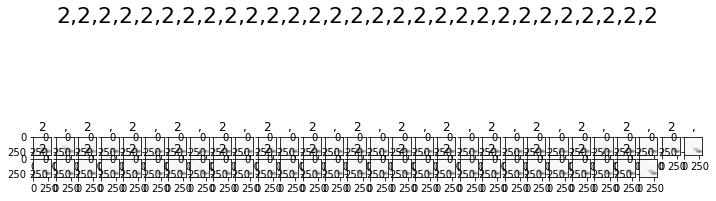

In [41]:
# captions on the validation set
result, attention_plot = evaluate(image_train[1], max_length_test)

print ('Real Caption:', caption_train[1])
print ('Prediction Caption:', ''.join(result[:-1]))

plot_attention(image_train[1], result, attention_plot)

# WER, MER, WIL, WIP

- WER = Word Error Rate
- MER = Match Error Rate
- WIL = Word Information Lost
- WIP = Word Information Preserved

In [ ]:
!pip install jiwer

In [43]:
import jiwer

transformation = jiwer.Compose([
    jiwer.ToLowerCase(),
    jiwer.RemoveMultipleSpaces(),
    jiwer.RemoveWhiteSpace(replace_by_space=False),
    jiwer.SentencesToListOfWords(word_delimiter=" ")
]) 

In [44]:
ground_truth, _ = kme_segment.word_segmentation(caption_test[0])
hypothesis, _ = evaluate(image_test[0], max_length_test)
score = jiwer.compute_measures(
    ground_truth,
    hypothesis[:-1], 
    truth_transform=transformation, 
    hypothesis_transform=transformation
)

print(ground_truth)
print(hypothesis[:-1])
print(score)

{'deletions': 0,
 'hits': 5,
 'insertions': 1,
 'mer': 0.16666666666666666,
 'substitutions': 0,
 'wer': 0.2,
 'wil': 0.16666666666666663,
 'wip': 0.8333333333333334}

# BLEU SCORE

In [45]:
import nltk
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

## All Bleu Score

In [46]:
import nltk
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from nami.AI.kme_tokenize import Segmentation
kme_segment = Segmentation()
score1, score2, score3, score4, score5, score6, score7 = [], [], [], [], [], [], []
best_score = {}
chencherry = SmoothingFunction()

for i in trange(len(image_test)):
  word_arr, _ = evaluate(image_test[i], max_length_test)

  real_word,_ = kme_segment.word_segmentation(caption_test[i])

  score1 = np.concatenate((score3, [sentence_bleu([real_word], word_arr[:-1], smoothing_function = chencherry.method1)]))
  score2 = np.concatenate((score3, [sentence_bleu([real_word], word_arr[:-1], smoothing_function = chencherry.method2)]))
  score3 = np.concatenate((score3, [sentence_bleu([real_word], word_arr[:-1], smoothing_function = chencherry.method3)]))
  score4 = np.concatenate((score4, [sentence_bleu([real_word], word_arr[:-1], smoothing_function = chencherry.method4)]))
  score5 = np.concatenate((score4, [sentence_bleu([real_word], word_arr[:-1], smoothing_function = chencherry.method5)]))
  #score6 = np.concatenate((score4, [sentence_bleu([real_word], words[1:-1], smoothing_function = chencherry.method6)]))
  score7 = np.concatenate((score4, [sentence_bleu([real_word], word_arr[:-1], smoothing_function = chencherry.method7)]))

In [47]:
print(f"BLEU1 {np.mean(score1)*100}\n"
      f"BLEU2 {np.mean(score2)*100}\n"
      f"BLEU3 {np.mean(score3)*100}\n"
      f"BLEU4 {np.mean(score4)*100}\n"
      f"BLEU5 {np.mean(score5)*100}\n"
      f"BLEU7 {np.mean(score7)*100}\n"
      )


BLEU1 21.23645599473506
BLEU2 21.300845500538973
BLEU3 21.26124567649779
BLEU4 24.48410373276261
BLEU5 24.4614983459343
BLEU7 24.510807647853177



In [48]:
best_score = {}
chencherry = SmoothingFunction()

for i in trange(len(image_test)):
  word_arr, _ = evaluate(image_test[i], max_length_test)
  real_word,_ = kme_segment.word_segmentation(caption_test[i])

  score = sentence_bleu([real_word], word_arr[:-1], smoothing_function = chencherry.method4)
  best_score[i] = score
  #print(f"{i} | {score:.4f}", end=' ')
  #print(''.join(word_arr[:-1]), end=' : ')
  #print(caption_test[i])

In [49]:
sort_best_score = sorted(best_score.items(), key=lambda x: x[1], reverse=True)

In [50]:
for i in range(30):
  print(sort_best_score[i][0], sort_best_score[i][1])

0 1.0
77 1.0
98 1.0
105 1.0
109 1.0
197 1.0
14 0.8408964152537145
30 0.7598356856515925
144 0.7598356856515925
249 0.7598356856515925
35 0.7419446627365011
38 0.7292571723872933
81 0.7272454093000141
130 0.7259795291154771
75 0.7165313105737893
62 0.6709489882833027
118 0.668740304976422
258 0.6606328636027614
255 0.6548907866815301
267 0.6223329772884784
16 0.6147881529512643
70 0.6147881529512643
13 0.6032482383565995
43 0.5873949094699213
263 0.5757575636202255
53 0.5462757644646491
169 0.513417119032592
193 0.513417119032592
213 0.513417119032592
93 0.5133450480401704


# Example

Real Caption: para-diethylbenzene
Prediction Caption: 1-methylcyclohexylcyclohexane


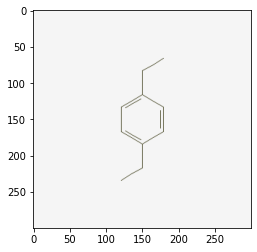

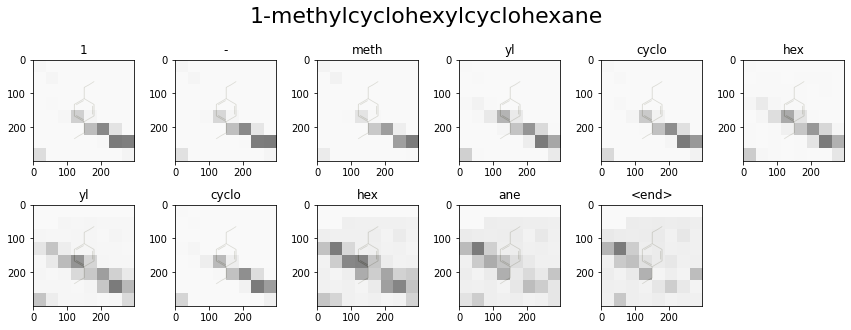

In [51]:
# captions on the validation set
result, attention_plot = evaluate(image_test[33], max_length_test)

print ('Real Caption:', caption_test[33])
print ('Prediction Caption:', ''.join(result[:-1]))
plt.imshow(image_test[33])
plt.show()
plot_attention(image_test[33], result, attention_plot)


Real Caption: 5-ethoxy-1,3-benzodioxole
Prediction Caption: 2-methoxy-1,3-benzodioxole


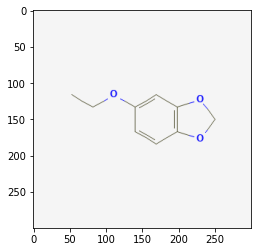

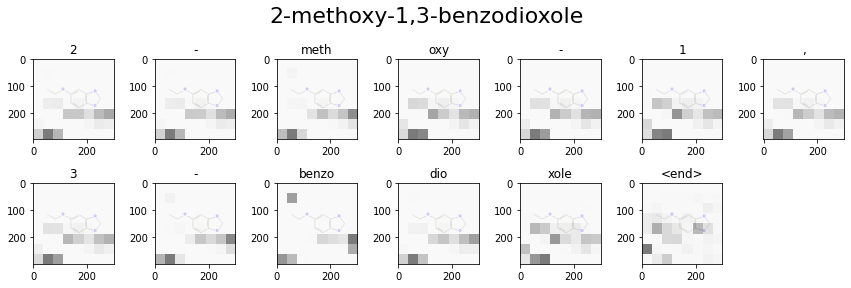

In [52]:
# captions on the validation set
result, attention_plot = evaluate(image_test[38], max_length_test)

print ('Real Caption:', caption_test[38])
print ('Prediction Caption:', ''.join(result[:-1]))
plt.imshow(image_test[38])
plt.show()
plot_attention(image_test[38], result, attention_plot)


Real Caption: 2-(difluoromethoxy)-3-methylhexane
Prediction Caption: 3-methylhexan-2-2-methylhexan-1-ene


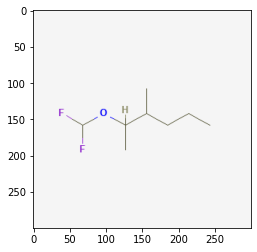

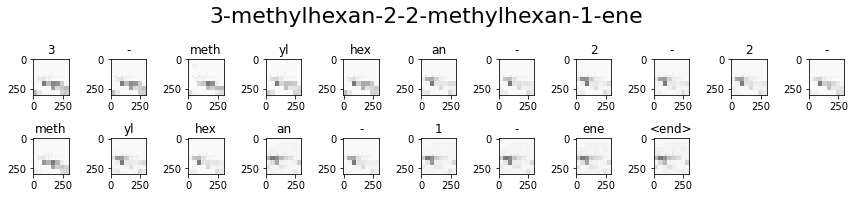

In [53]:
# captions on the validation set
result, attention_plot = evaluate(image_train[282], max_length_train)

print ('Real Caption:', caption_train[282])
print ('Prediction Caption:', ''.join(result[:-1]))
plt.imshow(image_train[282])
plt.show()
plot_attention(image_train[282], result, attention_plot)


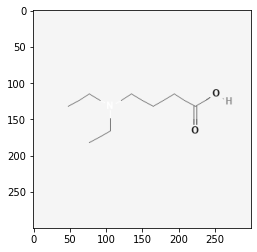

In [54]:
plt.imshow(image_train[0,:,:,0], cmap='gray')

Real Caption: 3,5-dimethylhex-1-ene
Prediction Caption: 2,4-methmethylhex-2-ene


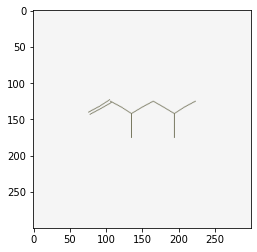

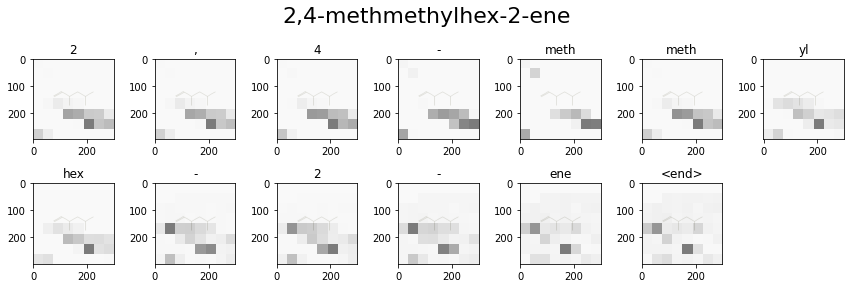

In [55]:
# captions on the validation set
result, attention_plot = evaluate(image_test[270], max_length_test)

print ('Real Caption:', caption_test[270])
print ('Prediction Caption:', ''.join(result[:-1]))
plt.imshow(image_test[270])
plt.show()
plot_attention(image_test[270], result, attention_plot)
